In [4]:
import torch

torch.cuda.empty_cache()

path_train = '../data/train_data.pkl'
path_val = '../data/val_data.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2 tensors of size 50000 x 3 x H x W
# denoise model with this data
noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:1000].type(torch.float)
noisy_imgs_2 = noisy_imgs_2[0:1000].type(torch.float)

# Normalize
norm_mean_1 = noisy_imgs_1.mean(dim = [2,3], keepdim = True)
norm_mean_2 = noisy_imgs_2.mean(dim = [2,3], keepdim = True)
norm_std_1 = noisy_imgs_1.std(dim = [2,3], keepdim = True)
norm_std_2 = noisy_imgs_2.std(dim = [2,3], keepdim = True)

norm_imgs_1 = (noisy_imgs_1 - norm_mean_1) / norm_std_1
norm_imgs_2 = (noisy_imgs_2 - norm_mean_2) / norm_std_2

# Track the progress with this data
noisy_imgs , clean_imgs = torch.load(path_val)
print(noisy_imgs_1.size())
print(noisy_imgs_2.size())
print(noisy_imgs.size())

print(clean_imgs.size())

norm_mean_1 = norm_mean_1.to(device)
norm_mean_2 = norm_mean_2.to(device)
norm_std_1 = norm_std_1.to(device)
norm_std_2 = norm_std_2.to(device)

print(norm_std_1.size())

torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 1, 1])


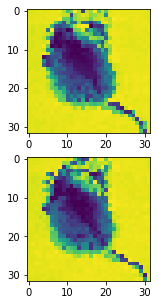

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(noisy_imgs_1[100,0]);
plt.subplot(2,1,2)
plt.imshow(noisy_imgs_2[100,0]);

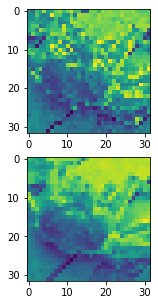

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(noisy_imgs[0,0]);
plt.subplot(2,1,2)
plt.imshow(clean_imgs[0,0]);

The goal is to find a model $\phi$:
$$\phi(\hat{X}) = X$$
Quadratic loss: 
$$\hat{w} = argmin \frac{1}{N} \sum_{n=1}^N || x_n - \phi(x_n + \epsilon_n;w) || ^2$$
* $x_n$: data samples
* $\epsilon_n$ : gaussian noise

In [4]:
import torch.nn.functional as F
import torch.nn as nn

model_old = nn.Sequential(
    nn.Linear(32, 100),
    nn.ReLU(),
    nn.Linear(100,32)
)

model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),    
    nn.Conv2d(32, 8, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(8, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, 3)
)

In [5]:
class Model_sum(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv2 = nn.Conv2d(24, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv3 = nn.Conv2d(24, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv4 = nn.Conv2d(24, 8, 3, padding=1, padding_mode = pad_mode)
        self.deconv1 = nn.ConvTranspose2d(8, 24, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(24, 24, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(24, 24, 3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(24, 3, 3, padding=1)
#         self.maxpool = F.max_pool2d(2)
        self.relu = nn.ReLU()
        self.lerelu = nn.LeakyReLU(0.1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        x1 = self.lerelu(self.conv1(x))
        x2 = self.lerelu(self.conv2(x1))
        x3 = self.lerelu(F.max_pool2d(x2, kernel_size = 2))
        x4 = self.lerelu(self.conv3(x3))
        x5 = self.lerelu(F.max_pool2d(x4, kernel_size = 2))
        x6 = self.lerelu(self.conv4(x5))
        x7 = self.lerelu(self.deconv1(x6)) + x5
        x7 = self.lerelu(self.upsample(x7))
        x7 = self.lerelu(self.deconv2(x7)) + x3
        x7 = self.lerelu(self.upsample(x7))
        x7 = self.lerelu(self.deconv3(x7)) + x1
        x7 = self.relu(self.deconv4(x7)) + x
        return x7


In [40]:
import torch.nn.functional as F

pad_mode = 'reflect'

def init_weights(model):
    if isinstance(model, nn.Conv2d):
        torch.nn.init.xavier_uniform(model.weight)
        model.bias.data.fill_(0.01)
    if isinstance(model, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform(model.weight)
        model.bias.data.fill_(0.01)
class Model_conc(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv2 = nn.Conv2d(24, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv3 = nn.Conv2d(24, 24, 3, padding=1, padding_mode = pad_mode)
        self.conv4 = nn.Conv2d(24, 8, 3, padding=1, padding_mode = pad_mode)
        self.conv5 = nn.Conv2d(6, 3, 3, padding=1, padding_mode = pad_mode)
        self.deconv1 = nn.ConvTranspose2d(8, 24, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(48, 24, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(48, 24, 3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(48, 3, 3, padding=1)
#         self.maxpool = F.max_pool2d(2)
        self.relu = nn.ReLU()
        self.lerelu = nn.LeakyReLU(0.1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        
        x1 = self.lerelu(self.conv1(x))
        x2 = self.lerelu(self.conv2(x1))
        x3 = self.lerelu(F.max_pool2d(x2, kernel_size = 2))
        x4 = self.lerelu(self.conv3(x3))
        x5 = self.lerelu(F.max_pool2d(x4, kernel_size = 2))
        x6 = self.lerelu(self.conv4(x5))
        x7 = torch.cat((self.lerelu(self.deconv1(x6)), x5), 1)
        x7 = self.lerelu(self.upsample(x7))
        x7 = torch.cat((self.lerelu(self.deconv2(x7)), x3), 1)
        x7 = self.lerelu(self.upsample(x7))
        x7 = torch.cat((self.lerelu(self.deconv2(x7)), x1), 1)
        x7 = self.lerelu(self.deconv4(x7))
        x7 = torch.cat((x7, x), 1)
        x7 = self.relu(self.conv5(x7))
        return x7
model = Model_conc()
model.apply(init_weights)

C:\Users\fcent\AppData\Local\Temp\ipykernel_23576\2610593444.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.weight)
C:\Users\fcent\AppData\Local\Temp\ipykernel_23576\2610593444.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.weight)


Model_conc(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv4): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv5): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (deconv1): ConvTranspose2d(8, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv4): ConvTranspose2d(48, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (lerelu): LeakyReLU(negative_slope=0.1)
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
)

In [41]:
from torch import nn
from tqdm import tqdm
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image

model = Model_conc().to(device)

transform = T.ToPILImage()

batch_size, nb_epochs = 100, 1000
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse = nn.MSELoss()
mse.to(device)

total_loss_conc = []

for e in tqdm(range(nb_epochs)):
    input = norm_imgs_1.to(device).split(batch_size)
    target = norm_imgs_2.to(device).split(batch_size)
    loss = 0
    for i in range(len(input)):
        output = model(input[i])
        loss += mse(output, target[i])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss_conc.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:06<00:00,  4.06it/s]


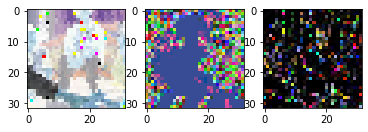

0.13090023398399353
0.2925923764705658


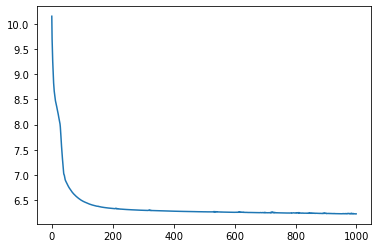

In [42]:
plt.figure()
n = 8
m = 10
plt.subplot(1, 3, 1)
plt.imshow(transform(input[n][m] * norm_std_1[n*100 + m] + norm_mean_1[n*100 + m]))
plt.subplot(1, 3, 2)
plt.imshow(transform(output[m] * norm_std_1[n*100 + m] + norm_mean_1[n*100 + m]))
plt.subplot(1, 3, 3)
# plt.imshow(transform(target[n][m] * norm_std_2[n *100 + m] + norm_mean_2[n*100 + m]))
plt.imshow(transform((input[n][m] - target[n][m])**2))
plt.show()

plt.figure()
plt.plot(total_loss_conc)
print(mse(input[8][0], target[8][0]).item())
print(mse(output[0], target[9][0]).item())

In [9]:
model = Model_sum().to(device)

transform = T.ToPILImage()

batch_size, nb_epochs = 100, 250
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse = nn.MSELoss()
mse.to(device)

total_loss_sum = []

for e in tqdm(range(nb_epochs)):
    input = norm_imgs_1.to(device).split(batch_size)
    target = norm_imgs_2.to(device).split(batch_size)
    loss = 0
    for i in range(len(input)):
        output = model(input[i])
        loss += mse(output, target[i])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss_sum.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.53it/s]


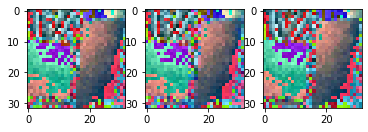

0.1451452672481537
0.12871383130550385
0.010999428108334541


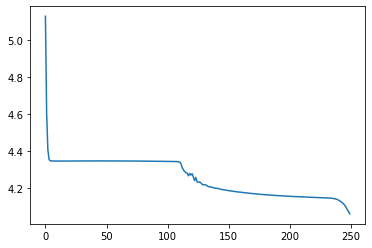

In [10]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(transform(input[9][0]))
plt.subplot(1, 3, 2)
plt.imshow(transform(output[0]))
plt.subplot(1, 3, 3)
plt.imshow(transform(target[9][0]))
plt.show()

plt.figure()
plt.plot(total_loss_sum)
print(mse(input[9][0], target[9][0]).item())
print(mse(output[0], target[9][0]).item())
print(mse(output[0], input[9][0]).item())

In [11]:
print(mse(input[9][0], target[9][0]).item())

0.1451452672481537


In [46]:
a = torch.arange(0,4**2).view(1,4,4).float()
print(a)
print(torch.nn.functional.fold(a, output_size = (3,3), kernel_size = (2,2)))

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]])
tensor([[[[ 0.,  5.,  5.],
          [10., 30., 20.],
          [10., 25., 15.]]]])


In [59]:
a = torch.ones((1,1,16,16)).float()
print(a)
b = torch.nn.functional.unfold(a, kernel_size = (3,3))
c = torch.nn.functional.fold(b, output_size = (16,16), kernel_size = (3,3))
print(c)

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1